# 시계열 데이터를 통한 다음달 매출 예측
  
<u>2013년 1월부터 2015년 10월까지</u>의 일일 기록 데이터를 통해 **2015년 11월 매출**을 예측해야 한다.  
  
평가 지표: **평균 제곱근 오차(RMSE)**, 실제 목표 값은 [0,20]범위
$$ RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^N (실제값 - 예측값)^2 } $$

|컬럼|뜻|
|:------|:---|
|ID|테스트 세트 내의 (Shop, Item)튜플을 나타내는 Id|
|shop_id|상점의 고유 식별자|
|item_id|상품의 고유 식별자|
|item_category_id|항목 카테고리의 고유 식별자|
|item_cnt_day|판매 된 제품 수. **우리는 해당값의 월별 금액을 예측중|
|item_price|상품의 현재 가격|
|date|dd/mm/yyyy 형식의 날짜|
|date_block_num|연속 월 번호(2013년 1월은 0, 2013년 2월은 1, ..., 2015년 10월은 33|
|item_name|항목 이름|
|shop_name|상점 이름|
|item_category_name|항목 카테고리 이름|

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

# 경고 문구 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 문제 해결
from matplotlib import font_manager, rc
font_path = "./malgun.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [2]:
# CSV 파일 모두 불러오기

sales_train = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [9]:
print('sales_train.columns:',sales_train.columns)
print('shops.columns',shops.columns)
print('items.columns',items.columns)
print('item_categories.columns',item_categories.columns)
print('test.columns',test.columns)
print('submission.columns',submission.columns)

sales_train.columns: Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
shops.columns Index(['shop_name', 'shop_id'], dtype='object')
items.columns Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
item_categories.columns Index(['item_category_name', 'item_category_id'], dtype='object')
test.columns Index(['ID', 'shop_id', 'item_id'], dtype='object')
submission.columns Index(['ID', 'item_cnt_month'], dtype='object')


submission이 제출해야 할 양식인데 'ID'와 'item_cnt_month'으로 이루어져 있다.  
test를 보면 'ID', 'shop_id', 'item_id'로 이루어져 있는데, 이를 통해 'ID'가 'shop_id'와 'item_id'의 조합이라는 것을 알 수 있다.  
나머지 sales_train, shops, items, item_categories는 각각 'shop_id', 'item_id', 'item_category_id'로 서로를 연결할 수 있다.  
  
'shop_id', 'item_id'를 기준으로 하고, 그에 더불어 월별 판매량을 구해야 하므로 'date_block_num'까지 기준으로 고려해야 한다.  
  
우선 sales_train을 중점적으로 보고, shops, items, item_categories를 차례대로 보도록 하겠다.

### 1) sales_train 데이터 탐방하기

In [10]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
sales_train.shape

(2935849, 6)

In [12]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


'date'를 제외하고는 모두 숫자형 데이터이다.  
'date'를 날짜로써 이용하고자 한다면 타입 변경을 시켜야 할 것 같다.

In [13]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


'item_price'의 경우 최소값을 봤을 때, 음수가 있다는 사실을 알 수 있고, 최대값이 매우 클 것이라고 예상할 수 있다.  
'item_cnt_day'의 경우에도 마찬가지로 음수가 있고, 최대값이 75% 수치와 비교할 때 매우 클 것이라고 생각할 수 있다.

<AxesSubplot:xlabel='item_price'>

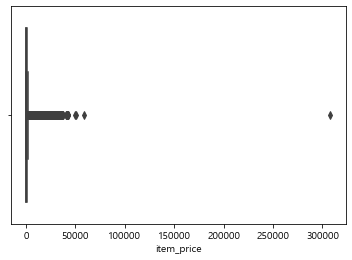

In [14]:
sns.boxplot(sales_train['item_price'])

<AxesSubplot:xlabel='item_cnt_day'>

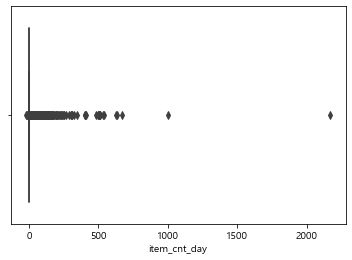

In [15]:
sns.boxplot(sales_train['item_cnt_day'])

박스플롯으로 확인하려 하니 극단치가 심하게 나타나 박스의 모습을 확인하기 힘들다.  
이상치에 대한 전처리가 필요하다.

In [16]:
# 아이템 가격이 0 초과 50000 미만인 구간 뽑기
sales_train = sales_train[sales_train['item_price'] > 0]
sales_train = sales_train[sales_train['item_price'] < 50000]

# 아이템 판매량이 0 초과 1000 미만인 구간 뽑기
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

<AxesSubplot:xlabel='item_price'>

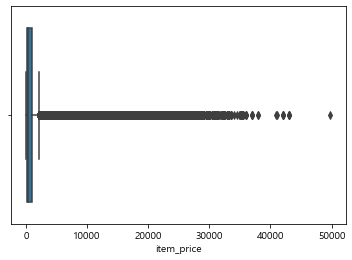

In [17]:
sns.boxplot(sales_train['item_price'])

<AxesSubplot:xlabel='item_cnt_day'>

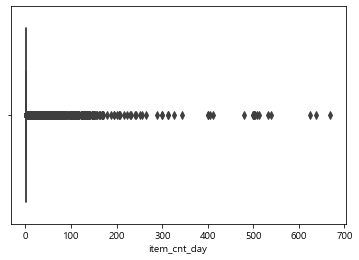

In [18]:
sns.boxplot(sales_train['item_cnt_day'])

여전히 이상치로 집계되는 것이 많지만 아까보다는 극단치의 영향이 줄었을 것이라고 예상할 수 있다.  
또한 범위를 벗어나는 수들이 매우 많아서 너무 범위를 좁게하면 오히려 악영향을 줄 수 있을 것이라고 생각했다.

### 2) shops 데이터 탐방

In [19]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [21]:
shops.describe(include='all')

,shop_name,shop_id
count,60,60.000000
unique,60,NaN
top,"Н.Новгород ТРЦ ""Фантастика""",NaN
freq,1,NaN
mean,NaN,29.500000
std,NaN,17.464249
min,NaN,0.000000
25%,NaN,14.750000
50%,NaN,29.500000
75%,NaN,44.250000


일단 상점 이름은 총 60개이다. 그에 따라 shop_id도 0~59이다.

하지만 상점 이름 몇 개를 구글 맵에 쳐본 결과 좌표가 거의 비슷하거나 똑같은 상점이 있다는 것을 발견하였다.  

![nn](KakaoTalk_20210611_143747061.png)

같은 상점이라고 확신할 수 없지만 좌표가 몰려 있는 지점이 있다는 것을 확인할 수 있다.  
그에 따라 구글 지오코딩 API를 이용하여 상점 이름을 차례대로 입력하여 좌표를 확인해보기로 했다.

In [22]:
shops['shop_name'].unique()    # 상점 이름

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [23]:
# !pip install -U googlemaps

In [24]:
# 지오코딩 API를 이용하여 좌표를 자동으로 불러오는 작업

import googlemaps

gmaps = googlemaps.Client(key='API키를발급받으셔서복사해서붙여넣으셔야합니다')    # 발급받은 API키
geocode_result = gmaps.geocode('!Якутск Орджоникидзе, 56 фран')    # 상점 이름 중 하나를 입력해 보았다.
print(geocode_result)

[{'address_components': [{'long_name': 'Yakutsk', 'short_name': 'Yakutsk', 'types': ['locality', 'political']}, {'long_name': 'Gorod Yakutsk', 'short_name': 'Gorod Yakutsk', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'Sakha Republic', 'short_name': 'Sakha Republic', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Russia', 'short_name': 'RU', 'types': ['country', 'political']}], 'formatted_address': 'Yakutsk, Sakha Republic, Russia', 'geometry': {'bounds': {'northeast': {'lat': 62.112907, 'lng': 129.8102418}, 'southwest': {'lat': 61.94975999999999, 'lng': 129.59333}}, 'location': {'lat': 62.03969120000001, 'lng': 129.7422192}, 'location_type': 'APPROXIMATE', 'viewport': {'northeast': {'lat': 62.112907, 'lng': 129.8102418}, 'southwest': {'lat': 61.94975999999999, 'lng': 129.59333}}}, 'partial_match': True, 'place_id': 'ChIJfcTSoDk59lsR-6KvXLPEtGk', 'types': ['locality', 'political']}]


잘 보니 'location'에 'lat'과 'lng'가 있다는 것을 확인할 수 있다.

In [25]:
geocode_result[0]['geometry']['location']    # 좌표 부분만 시험삼아 뽑아 보았다.

{'lat': 62.03969120000001, 'lng': 129.7422192}

In [26]:
# 상점 이름을 통해 좌표를 모두 불러왔다.

a = -1
shop_geo_list = []
for i in shops['shop_name'].unique():
    a += 1
    try:
        geocode_result = gmaps.geocode(str(i))
        print(a,'번째',i,':',geocode_result[0]['geometry']['location'])
        shop_geo_list.append(geocode_result[0]['geometry']['location'])
    except:    # 구글맵에서 검색이 되지 않는 경우, 에러를 발생시키지 않고 다음으로 넘어간다.
        continue

0 번째 !Якутск Орджоникидзе, 56 фран : {'lat': 62.03969120000001, 'lng': 129.7422192}
1 번째 !Якутск ТЦ "Центральный" фран : {'lat': 62.0304865, 'lng': 129.7412868}
2 번째 Адыгея ТЦ "Мега" : {'lat': 45.01274129999999, 'lng': 38.93038689999999}
3 번째 Балашиха ТРК "Октябрь-Киномир" : {'lat': 55.7943382, 'lng': 37.9266814}
4 번째 Волжский ТЦ "Волга Молл" : {'lat': 48.7719457, 'lng': 44.7998202}
5 번째 Вологда ТРЦ "Мармелад" : {'lat': 59.1969752, 'lng': 39.8597694}
6 번째 Воронеж (Плехановская, 13) : {'lat': 51.6636264, 'lng': 39.1972743}
7 번째 Воронеж ТРЦ "Максимир" : {'lat': 51.69688679999999, 'lng': 39.2732515}
8 번째 Воронеж ТРЦ Сити-Парк "Град" : {'lat': 51.7888889, 'lng': 39.205}
9 번째 Выездная Торговля : {'lat': 52.28100999999999, 'lng': 104.28581}
10 번째 Жуковский ул. Чкалова 39м? : {'lat': 55.597069, 'lng': 38.123645}
11 번째 Жуковский ул. Чкалова 39м² : {'lat': 55.597581, 'lng': 38.1245051}
12 번째 Интернет-магазин ЧС : {'lat': 33.2220412, 'lng': -97.08900849999999}
13 번째 Казань ТЦ "Бехетле" : {'lat':

상점 이름은 물론 좌표도 비슷하거나 같은 것들이 있다.  
하지만 일일이 비교하기에는 힘들기 때문에 좌표를 계산하는 패키지를 불러와서 계산하기로 했다.

In [27]:
# !pip install haversine

In [28]:
# 좌표를 통해 거리 계산할 수 있는 패키지
from haversine import haversine

In [29]:
count = []
for i, v in enumerate(shop_geo_list):
    for i1, v1 in enumerate(shop_geo_list):
        if (i == i1) or (i1 in count):
            continue
        if haversine((v['lat'],v['lng']), (v1['lat'],v1['lng']), unit = 'm') < 100: # 거리계산 결과, 100m 이내에 shop이 존재하는 경우
            count.append(i)
            count.append(i1)
            print(i,v,'||',i1,v1)

1 {'lat': 62.0304865, 'lng': 129.7412868} || 57 {'lat': 62.0304865, 'lng': 129.7412868}
10 {'lat': 55.597069, 'lng': 38.123645} || 11 {'lat': 55.597581, 'lng': 38.1245051}
23 {'lat': 55.7581352, 'lng': 37.7412647} || 24 {'lat': 55.7581352, 'lng': 37.7412647}
39 {'lat': 47.25972220000001, 'lng': 39.71944440000001} || 40 {'lat': 47.25972220000001, 'lng': 39.71944440000001}


0 번째 !Якутск Орджоникидзе, 56 фран : {'lat': 62.03969120000001, 'lng': 129.7422192}  
1 번째 !Якутск ТЦ "Центральный" фран : {'lat': 62.0304865, 'lng': 129.7412868}  
57 번째 Якутск Орджоникидзе, 56 : {'lat': 62.025098, 'lng': 129.720242}  
58 번째 Якутск ТЦ "Центральный" : {'lat': 62.0304865, 'lng': 129.7412868}  
구글맵에서는 фран이 생략된 채로 검색됨  
  
0 - 57  
1 - 58(아예 똑같음) 각각 짝지어줘야 함  
  
지오코딩API를 통해서 나온 좌표값과 구글맵 좌표값이 다르다.(구글맵에서는 57: @62.0295503,129.7290346) 의문스럽다.  
10 - 11: 거리는 가까운 곳에 있으나 지도에서 보면 다른 가게이다. 따라서 포함하지 않겠다.  

10번 가게
![nn](KakaoTalk_20210614_144958786.png)

11번 가게  
![aa](KakaoTalk_20210614_144931912.png)

In [30]:
# sales_train에 중복되는 상점 id 맞춰주기
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 23, 'shop_id'] = 24
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

# test
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 23, 'shop_id'] = 24
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

In [31]:
test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 40, 45], dtype=int64)

In [32]:
sales_train['shop_id'].unique()

array([59, 25, 24, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7, 57,
       58, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47, 50,
       42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 55, 17,  9, 49, 40, 48,
       34, 33, 20, 11, 36], dtype=int64)

In [33]:
len(sales_train['shop_id'].unique())

56

60개에서 56개로 바뀌었다.

In [34]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [35]:
# 46번 데이터 오류 수정(띄어쓰기 때문에 카테고리 인식에 오류가 나타남 -> 띄어쓰기 붙여서 다시 나타냄)
shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

# 'shop_name'에서 공백(띄어쓰기)을 기준으로 각각 0번째와 1번째는 'shop_city' 와 'shop_category'에 해당
shops['shop_city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['shop_category'] = shops['shop_name'].str.split(' ').map(lambda x: x[1])
shops

,shop_name,shop_id,shop_city,shop_category
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",6,Воронеж,"(Плехановская,"
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,Торговля


In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
shops['shop_city']  = LabelEncoder().fit_transform(shops['shop_city'] )         # 라벨인코더를 통해 도시 이름을 숫자로 변환
shops['shop_category'] = LabelEncoder().fit_transform(shops['shop_category'])   # 라벨인코더를 통해 카테고리 이름을 숫자로 변환
shops.head()

,shop_name,shop_id,shop_city,shop_category
0,"!Якутск Орджоникидзе, 56 фран",0,0,4
1,"!Якутск ТЦ ""Центральный"" фран",1,0,8
2,"Адыгея ТЦ ""Мега""",2,1,8
3,"Балашиха ТРК ""Октябрь-Киномир""",3,2,6
4,"Волжский ТЦ ""Волга Молл""",4,3,8


In [38]:
shops.drop(['shop_name'], axis=1, inplace= True)   # 상점 이름 열 삭제
shops.head()

,shop_id,shop_city,shop_category
0,0,0,4
1,1,0,8
2,2,1,8
3,3,2,6
4,4,3,8


### 3) items, items_categories 데이터 탐방

In [39]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [40]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


두 데이터는 'item_category_id'를 통해 연결할 수 있다.

In [41]:
# 공통의 열('item_category_id')을 기준으로 두 데이터프레임을 합쳐주기
items = pd.merge(items, item_categories, on = 'item_category_id')
items

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания


In [42]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [43]:
# 아이템 카테코리 이름 뽑기
cnt = 0
for i in item_categories['item_category_name']:
    print(cnt,'번째:',i)
    cnt += 1

0 번째: PC - Гарнитуры/Наушники
1 번째: Аксессуары - PS2
2 번째: Аксессуары - PS3
3 번째: Аксессуары - PS4
4 번째: Аксессуары - PSP
5 번째: Аксессуары - PSVita
6 번째: Аксессуары - XBOX 360
7 번째: Аксессуары - XBOX ONE
8 번째: Билеты (Цифра)
9 번째: Доставка товара
10 번째: Игровые консоли - PS2
11 번째: Игровые консоли - PS3
12 번째: Игровые консоли - PS4
13 번째: Игровые консоли - PSP
14 번째: Игровые консоли - PSVita
15 번째: Игровые консоли - XBOX 360
16 번째: Игровые консоли - XBOX ONE
17 번째: Игровые консоли - Прочие
18 번째: Игры - PS2
19 번째: Игры - PS3
20 번째: Игры - PS4
21 번째: Игры - PSP
22 번째: Игры - PSVita
23 번째: Игры - XBOX 360
24 번째: Игры - XBOX ONE
25 번째: Игры - Аксессуары для игр
26 번째: Игры Android - Цифра
27 번째: Игры MAC - Цифра
28 번째: Игры PC - Дополнительные издания
29 번째: Игры PC - Коллекционные издания
30 번째: Игры PC - Стандартные издания
31 번째: Игры PC - Цифра
32 번째: Карты оплаты (Кино, Музыка, Игры)
33 번째: Карты оплаты - Live!
34 번째: Карты оплаты - Live! (Цифра)
35 번째: Карты оплаты - PSN
36 번째: Карт

In [44]:
# 카테고리 이름 지정(영어로 번역)
items['item_sub_cat_1'] = np.select( 
    [items.item_category_id==0,
    items.item_category_id.isin(range(1,8)),     # 1-7
    items.item_category_id.isin(range(10,18)),   # 10-17
    items.item_category_id.isin(range(18,32)),   # 18-31
    items.item_category_id.isin(range(32,37)),
    items.item_category_id.isin(range(37,42)),
    items.item_category_id.isin(range(42,55)),
    items.item_category_id.isin(range(55,61)),
    items.item_category_id.isin(range(61,73)),
    items.item_category_id.isin(range(73,79)),
    items.item_category_id.isin([8,80]),
    items.item_category_id==83, 
    items.item_category_id==9,
    items.item_category_id==79,  
    items.item_category_id.isin([81,82])],

    ['Headsets / Headphones','Accessories','Game_consoles','Games','Payment_cards','Cinema_Blu_Ray','Books','Music',
     'Presents','Programs','Tickets','Batteries','Delivery','Service','Blank_media'])

In [45]:
items

,item_name,item_id,item_category_id,item_category_name,item_sub_cat_1
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Cinema_Blu_Ray
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Cinema_Blu_Ray
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Cinema_Blu_Ray
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Cinema_Blu_Ray
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Cinema_Blu_Ray
...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Batteries
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Batteries
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Batteries
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Batteries


'item_sub_cat_1'컬럼에 영어로 번역된 카테고리 이름이 지정되어 있는 모습을 확인할 수 있다.

In [46]:
# 라벨인코더를 통해 'item_sub_cat_1'의 문자형 데이터를 숫자형으로 변환
items['item_sub_cat_1'] = LabelEncoder().fit_transform(items['item_sub_cat_1'])
items.head()

,item_name,item_id,item_category_id,item_category_name,item_sub_cat_1
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,4
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,4
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,4
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,4
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,4


In [47]:
# 숫자형만 남기고 아이템 이름 , 카테고리 이름 삭제
items.drop(['item_name','item_category_name'], axis=1, inplace= True)
items.head()

,item_id,item_category_id,item_sub_cat_1
0,0,40,4
1,2,40,4
2,3,40,4
3,4,40,4
4,5,40,4


### + 모든 조합을 구하는 df 데이터프레임 만들기

In [48]:
from itertools import product

# product: 데카르트곱 표현할 때 사용하는 메소드, 두 개 이상의 리스트의 모든 조합을 구할 때 사용
# _list = ["012", "abc", "DEF"]
# pd = list(product(*_list))
# pd

In [49]:
# 'date_block_num'을 기준으로 'shop_id'와 'item_id'의 모든 조합을 구하는 코드

df = []    # 모든 조합을 저장할 빈 리스트
idx_cols = ['date_block_num','shop_id','item_id']

for i in range(34):    # 0 ~ 33까지 (2013-01 ~ 2015-10 기간을 뜻함)
    df_sales = sales_train[sales_train['date_block_num'] == i]    # 각 월에 해당하는 sales_train만 뽑아서 df_sales에 저장
    df.append(np.array(list(product([i], df_sales.shop_id.unique(), df_sales.item_id.unique())), dtype='int16'))
    
df = pd.DataFrame(np.vstack(df), columns = idx_cols)           # vstack: 배열을 세로로 결합할 때 사용

df['date_block_num'] = df['date_block_num'].astype(np.int8)    # np.int8은 2^8(256)까지 표현 가능
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)

df.sort_values(idx_cols, inplace=True)    # 위에서 정한 컬럼 리스트대로 정렬
df

,date_block_num,shop_id,item_id
106728,0,2,19
108966,0,2,27
112441,0,2,28
110132,0,2,29
106421,0,2,32
...,...,...,...
10635090,33,59,22162
10635280,33,59,22163
10635946,33,59,22164
10637472,33,59,22166


위에서 product를 통해 'date_block_num', 'shop_id', 'item_id'의 모든 조합 구하여  
vstack을 통해서 세로로 쌓고,  컬럼 ['date_block_num', 'shop_id', 'item_id'] 순으로 정렬하여 표현하였다.

### 4) test 데이터 탐방

In [50]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [51]:
# test의 'ID'열을 제거한다.
test.drop(['ID'], axis=1, inplace = True)

# test에 'date_block_num'컬럼을 추가한다.
# 다만 sales_train에서 'date_block_num'의 범위가 0 ~ 33이므로 test에서는 34를 값으로 넣어준다.
test['date_block_num'] = 34

test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


'ID'열이 사라지고 'date_block_num'열이 생겼다.

In [52]:
# df와 test 데이터를 합쳐준다.
df = pd.concat([df, test], ignore_index = True, sort = False, keys = idx_cols)
# concat: 데이터의 속성 형태가 동일한 데이터 합치기

df.head()

,date_block_num,shop_id,item_id
0,0,2,19
1,0,2,27
2,0,2,28
3,0,2,29
4,0,2,32


In [53]:
# 위에서 정리해준 shops와 items 데이터를 df에 합쳐준다.
df = pd.merge(df, shops, on=['shop_id'], how='left')    # merge: 공통의 열을 기준으로 두 데이터프레임을 합쳐주기
df = pd.merge(df, items, on=['item_id'], how='left')    # on: 합치는 기준, how='left': 두 데이터 중에서도 왼쪽 데이터를 기준으로 합침
df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1
0,0,2,19,1,8,40,4
1,0,2,27,1,8,19,7
2,0,2,28,1,8,30,7
3,0,2,29,1,8,23,7
4,0,2,32,1,8,40,4


차례대로 shop에 관한 컬럼이 2개, 아이템에 관한 컬럼이 2개 합쳐져 있는 모습을 확인할 수 있다.

In [54]:
df.fillna(0, inplace=True)    # 결측값을 0으로 대체
df

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1
0,0,2,19,1,8,40,4
1,0,2,27,1,8,19,7
2,0,2,28,1,8,30,7
3,0,2,29,1,8,23,7
4,0,2,32,1,8,40,4
...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9
10994248,34,45,16188,21,8,64,11
10994249,34,45,15757,21,8,55,9
10994250,34,45,19648,21,8,40,4


In [55]:
# 메모리 사용 줄이기 위해 열 유형 변경
df['date_block_num']    = df['date_block_num'].astype(np.int8)
df['shop_id']           = df['shop_id'].astype(np.int8)
df['item_id']           = df['item_id'].astype(np.int16)
df['shop_city']         = df['shop_city'].astype(np.int8)
df['shop_category']     = df['shop_category'].astype(np.int8)
df['item_category_id']  = df['item_category_id'].astype(np.int8)
df['item_sub_cat_1']    = df['item_sub_cat_1'].astype(np.int8)

### 5) df와 sales_train의 만남

In [56]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [57]:
# 'shop_id','item_id','date_block_num'를 기준으로 groupby하고,
# agg를 통해 'item_cnt_day'를 'ID'와 월별을 기준으로 합(sum)한 것을 'item_cnt_month'에 할당
temp = sales_train.groupby(['shop_id','item_id','date_block_num']).agg(item_cnt_month = ('item_cnt_day', sum))
temp

item_cnt_month
shop_id item_id date_block_num                
2       27      0                          1.0
                17                         1.0
        30      2                          1.0
                5                          1.0
                15                         1.0
...                                        ...
59      22164   27                         2.0
                30                         1.0
        22167   9                          1.0
                11                         2.0
                17                         1.0

[1605870 rows x 1 columns]

In [58]:
temp.reset_index(inplace=True)    # 인덱스 초기화
temp

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0
...,...,...,...,...
1605865,59,22164,27,2.0
1605866,59,22164,30,1.0
1605867,59,22167,9,1.0
1605868,59,22167,11,2.0


In [59]:
df = pd.merge(df, temp, on = idx_cols, how = 'left')
df

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month
0,0,2,19,1,8,40,4,NaN
1,0,2,27,1,8,19,7,1.0
2,0,2,28,1,8,30,7,NaN
3,0,2,29,1,8,23,7,NaN
4,0,2,32,1,8,40,4,NaN
...,...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9,NaN
10994248,34,45,16188,21,8,64,11,NaN
10994249,34,45,15757,21,8,55,9,NaN
10994250,34,45,19648,21,8,40,4,NaN


'date_block_num', 'shop_id', 'item_id'를 기준으로  
df의 컬럼인 'shop_city','shop_category','item_category_id','item_sub_cat_1'와  
temp의 컬럼인 'item_cnt_month'가 차례대로 합쳐졌다.

In [60]:
df['item_cnt_month'] = (df['item_cnt_month'].fillna(0)            # 결측치를 0으로 변환
                                            .clip(0, 20)          # 0-20 범위
                                            .astype(np.float16))
df

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month
0,0,2,19,1,8,40,4,0.0
1,0,2,27,1,8,19,7,1.0
2,0,2,28,1,8,30,7,0.0
3,0,2,29,1,8,23,7,0.0
4,0,2,32,1,8,40,4,0.0
...,...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9,0.0
10994248,34,45,16188,21,8,64,11,0.0
10994249,34,45,15757,21,8,55,9,0.0
10994250,34,45,19648,21,8,40,4,0.0


In [62]:
# lag 컬럼을 만드는 함수(여기에서 lag는 지연(delay)을 뜻한다.)
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    # 기준 컬럼인 'date_block_num', 'shop_id', 'item_id'와 lag 컬럼을 만들 컬럼(col)만 df에서 선택하여 tmp에 저장한다.
    
    for i in lags:
        shifted = tmp.copy()    # shifted에 tmp 복사
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]    # 컬럼 이름을 지정
        shifted['date_block_num'] += i    # i를 더하여 1달을 기준으로 밀린다.(만약 lags가 3이면 1달, 2달, 3달이 밀린다.)
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        # df와 shifted를 병합한다.
    return df

# 결측치 채우는 함수
def fill_na_test(df):
    for col in df.columns:
        if ('_lag' in col) & (df[col].isnull().any()):    # 만약 lag 컬럼이고, 결측치가 하나라도 있으면
            print(col)                                     # 결측치가 있는 컬럼의 이름을 print한다.
            if ('month' in col):                   # 컬럼 이름에 'month'가 있다면
                df[col].fillna(0, inplace=True)    # 결측치를 0으로 채운다.    
    return df

In [63]:
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')    # 'item_cnt_month'를 기준으로 lag 컬럼을 3개 만들었다.

In [64]:
df

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,2,19,1,8,40,4,0.0,NaN,NaN,NaN
1,0,2,27,1,8,19,7,1.0,NaN,NaN,NaN
2,0,2,28,1,8,30,7,0.0,NaN,NaN,NaN
3,0,2,29,1,8,23,7,0.0,NaN,NaN,NaN
4,0,2,32,1,8,40,4,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9,0.0,1.0,0.0,0.0
10994248,34,45,16188,21,8,64,11,0.0,0.0,0.0,NaN
10994249,34,45,15757,21,8,55,9,0.0,0.0,0.0,0.0
10994250,34,45,19648,21,8,40,4,0.0,0.0,0.0,0.0


'tem_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3' 컬럼이 생긴 것을 확인할 수 있다.

In [65]:
df = fill_na_test(df)    # 결측치 채우기
df

item_cnt_month_lag_1
item_cnt_month_lag_2
item_cnt_month_lag_3


,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,2,19,1,8,40,4,0.0,0.0,0.0,0.0
1,0,2,27,1,8,19,7,1.0,0.0,0.0,0.0
2,0,2,28,1,8,30,7,0.0,0.0,0.0,0.0
3,0,2,29,1,8,23,7,0.0,0.0,0.0,0.0
4,0,2,32,1,8,40,4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9,0.0,1.0,0.0,0.0
10994248,34,45,16188,21,8,64,11,0.0,0.0,0.0,0.0
10994249,34,45,15757,21,8,55,9,0.0,0.0,0.0,0.0
10994250,34,45,19648,21,8,40,4,0.0,0.0,0.0,0.0


In [66]:
# 'date_block_num'로 groupby하고 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
temp.head()

,item_cnt_month
,mean
date_block_num,
0,0.355713
1,0.332031
2,0.363770
3,0.288330
4,0.265625


In [67]:
temp.columns = ['avg_month']     # 컬럼 이름을 바꾸었다.
temp.reset_index(inplace=True)  # 인덱스 초기화
temp.head()

,date_block_num,avg_month
0,0,0.355713
1,1,0.332031
2,2,0.363770
3,3,0.288330
4,4,0.265625


In [68]:
# df와 temp를 'date_block_num'을 기준으로 합친다.
df = pd.merge(df, temp, on=['date_block_num'], how='left')
df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_month
0,0,2,19,1,8,40,4,0.0,0.0,0.0,0.0,0.355713
1,0,2,27,1,8,19,7,1.0,0.0,0.0,0.0,0.355713
2,0,2,28,1,8,30,7,0.0,0.0,0.0,0.0,0.355713
3,0,2,29,1,8,23,7,0.0,0.0,0.0,0.0,0.355713
4,0,2,32,1,8,40,4,0.0,0.0,0.0,0.0,0.355713


In [69]:
# 'avg_month'에 대한 lag 컬럼을 3개 만든다.
df = lag_feature(df, [1, 2, 3], 'avg_month')

# 'avg_month'컬럼을 삭제
df.drop(['avg_month'], axis=1, inplace= True)

df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_month_lag_1,avg_month_lag_2,avg_month_lag_3
0,0,2,19,1,8,40,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,0,2,27,1,8,19,7,1.0,0.0,0.0,0.0,NaN,NaN,NaN
2,0,2,28,1,8,30,7,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,0,2,29,1,8,23,7,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,0,2,32,1,8,40,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [70]:
# 월별, 아이템별 'item_cnt_month'의 평균값 구하기
temp = df.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_month']
temp.reset_index(inplace=True)
temp.head()

,date_block_num,item_id,avg_item_month
0,0,19,0.022720
1,0,27,0.159058
2,0,28,0.181763
3,0,29,0.113647
4,0,32,5.500000


In [71]:
df = pd.merge(df, temp, on=['date_block_num', 'item_id'], how='left')
df = lag_feature(df, [1, 2, 3], 'avg_item_month')
df.drop(['avg_item_month'], axis=1, inplace= True)
df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_month_lag_1,avg_month_lag_2,avg_month_lag_3,avg_item_month_lag_1,avg_item_month_lag_2,avg_item_month_lag_3
0,0,2,19,1,8,40,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1,8,19,7,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,1,8,30,7,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,1,8,23,7,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,1,8,40,4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# 월별, 상점별 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shop_month']
temp.reset_index(inplace=True)
df = pd.merge(df, temp, on=['date_block_num', 'shop_id'], how='left')
df = lag_feature(df, [1, 2, 3], 'avg_shop_month')
df.drop(['avg_shop_month'], axis=1, inplace= True)

# 월별, 아이템카테고리별 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_cat_month']
temp.reset_index(inplace=True)
df = pd.merge(df, temp, on=['date_block_num', 'item_category_id'], how='left')
df = lag_feature(df, [1,2], 'avg_item_cat_month')
df.drop(['avg_item_cat_month'], axis=1, inplace= True)

# 월별, 상점별, 아이템카테고리별 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_itemcat_month']
temp.reset_index(inplace=True)
df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
df = lag_feature(df, [1,2], 'avg_shops_itemcat_month')
df.drop(['avg_shops_itemcat_month'], axis=1, inplace= True)

# 월별, 상점별, 아이템별 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_month']
temp.reset_index(inplace=True)
df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df = lag_feature(df, [1,2], 'avg_shops_item_month')
df.drop(['avg_shops_item_month'], axis=1, inplace= True)

# 월별, 상점별, 서브카테고리별 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num', 'shop_id', 'item_sub_cat_1']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_sub_month']
temp.reset_index(inplace=True)
df = pd.merge(df, temp, on=['date_block_num', 'shop_id', 'item_sub_cat_1'], how='left')
df = lag_feature(df, [1,2], 'avg_shops_item_sub_month')
df.drop(['avg_shops_item_sub_month'], axis=1, inplace= True)

# 월별, 도시별 'item_cnt_month'의 평균 구하기
temp = df.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shopscity_month']
temp.reset_index(inplace=True)
df = pd.merge(df, temp, on=['date_block_num', 'shop_city'], how='left')
df = lag_feature(df, [1,2], 'avg_shopscity_month')
df.drop(['avg_shopscity_month'], axis=1, inplace= True)

Use time: 218.15437126159668


In [73]:
# 'date_block_num'을 12로 나눈 나머지를 통해 몇 월인지 알 수 있다. (0 ~ 11)
df['month'] = df['date_block_num'] % 12
df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_cat_month_lag_2,avg_shops_itemcat_month_lag_1,avg_shops_itemcat_month_lag_2,avg_shops_item_month_lag_1,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month
0,0,2,19,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,2,27,1,8,19,7,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,2,28,1,8,30,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,2,29,1,8,23,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,2,32,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [74]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])   # 1월부터 12월까지 일수
df['days'] = df['month'].map(days)    # df['month']는 0~11  ->  각 위치마다 해당 월의 일수가 할당됨
df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_shops_itemcat_month_lag_1,avg_shops_itemcat_month_lag_2,avg_shops_item_month_lag_1,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month,days
0,0,2,19,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31
1,0,2,27,1,8,19,7,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31
2,0,2,28,1,8,30,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31
3,0,2,29,1,8,23,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31
4,0,2,32,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31


In [75]:
df['years'] = np.select(
    [df['date_block_num'].isin(range(0,12)),     # 0 ~ 11 사이(1년차 - 2013년도)
     df['date_block_num'].isin(range(12,24)),    # 12 ~ 23 사이(2년차 - 2014년도)
     df['date_block_num'].isin(range(24,36))],   # 24 ~ 35 사이(3년차 - 2015년도)
    ['13','14','15'])   # 각각 'years'컬럼에 13, 14, 15를 할당

df['month'] = df['month'] + 1  # 0 ~ 11   ->   1 ~ 12월로 바꾼다.

# 메모리 절약 위함
df['days'] = df['days'].astype(np.int8)
df['month'] = df['month'].astype(np.int8)
df['years'] = df['years'].astype(np.int8)
df

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_shops_itemcat_month_lag_2,avg_shops_item_month_lag_1,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month,days,years
0,0,2,19,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
1,0,2,27,1,8,19,7,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
2,0,2,28,1,8,30,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
3,0,2,29,1,8,23,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
4,0,2,32,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9,0.0,1.0,0.0,...,0.074524,1.0,0.0,0.089294,0.053802,0.135498,0.139404,11,30,15
10994248,34,45,16188,21,8,64,11,0.0,0.0,0.0,...,0.117126,0.0,0.0,0.106262,0.112732,0.135498,0.139404,11,30,15
10994249,34,45,15757,21,8,55,9,0.0,0.0,0.0,...,0.074524,0.0,0.0,0.089294,0.053802,0.135498,0.139404,11,30,15
10994250,34,45,19648,21,8,40,4,0.0,0.0,0.0,...,0.074097,0.0,0.0,0.097046,0.073303,0.135498,0.139404,11,30,15


In [76]:
# 해당 상점에서 해당 아이템이 팔린 달로부터 몇 달이 되었는지를 컬럼으로 추가
df['item_shop_first_sale'] = df['date_block_num'] - df.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
# 'item_id', 'shop_id'를 기준으로 groupby한 후 'date_block_num'에 대해서 최소값을 구한다. == 해당 상점에서 처음으로 해당 상품 판 달

# 처음으로 해당 아이템이 팔린 달로부터 몇 달이 되었는지를 컬럼으로 추가
df['item_first_sale'] = df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')
# 'item_id'를 기준으로 groupby한 후 'date_block_num'에 대해서 최소값을 구한다. == 처음으로 해당 상품이 팔린 달
df

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month,days,years,item_shop_first_sale,item_first_sale
0,0,2,19,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
1,0,2,27,1,8,19,7,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
2,0,2,28,1,8,30,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
3,0,2,29,1,8,23,7,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
4,0,2,32,1,8,40,4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1,31,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994247,34,45,18454,21,8,55,9,0.0,1.0,0.0,...,0.0,0.089294,0.053802,0.135498,0.139404,11,30,15,11,11
10994248,34,45,16188,21,8,64,11,0.0,0.0,0.0,...,0.0,0.106262,0.112732,0.135498,0.139404,11,30,15,2,2
10994249,34,45,15757,21,8,55,9,0.0,0.0,0.0,...,0.0,0.089294,0.053802,0.135498,0.139404,11,30,15,34,34
10994250,34,45,19648,21,8,40,4,0.0,0.0,0.0,...,0.0,0.097046,0.073303,0.135498,0.139404,11,30,15,11,11


In [77]:
# 결측치 확인
df.isnull().any()

date_block_num                    False
shop_id                           False
item_id                           False
shop_city                         False
shop_category                     False
item_category_id                  False
item_sub_cat_1                    False
item_cnt_month                    False
item_cnt_month_lag_1              False
item_cnt_month_lag_2              False
item_cnt_month_lag_3              False
avg_month_lag_1                    True
avg_month_lag_2                    True
avg_month_lag_3                    True
avg_item_month_lag_1               True
avg_item_month_lag_2               True
avg_item_month_lag_3               True
avg_shop_month_lag_1               True
avg_shop_month_lag_2               True
avg_shop_month_lag_3               True
avg_item_cat_month_lag_1           True
avg_item_cat_month_lag_2           True
avg_shops_itemcat_month_lag_1      True
avg_shops_itemcat_month_lag_2      True
avg_shops_item_month_lag_1         True


In [78]:
df = fill_na_test(df)    # 결측치 제거하는 함수 이용
df.isnull().any()        # 다시 한 번 결측치 확인

avg_month_lag_1
avg_month_lag_2
avg_month_lag_3
avg_item_month_lag_1
avg_item_month_lag_2
avg_item_month_lag_3
avg_shop_month_lag_1
avg_shop_month_lag_2
avg_shop_month_lag_3
avg_item_cat_month_lag_1
avg_item_cat_month_lag_2
avg_shops_itemcat_month_lag_1
avg_shops_itemcat_month_lag_2
avg_shops_item_month_lag_1
avg_shops_item_month_lag_2
avg_shops_item_sub_month_lag_1
avg_shops_item_sub_month_lag_2
avg_shopscity_month_lag_1
avg_shopscity_month_lag_2


date_block_num                    False
shop_id                           False
item_id                           False
shop_city                         False
shop_category                     False
item_category_id                  False
item_sub_cat_1                    False
item_cnt_month                    False
item_cnt_month_lag_1              False
item_cnt_month_lag_2              False
item_cnt_month_lag_3              False
avg_month_lag_1                   False
avg_month_lag_2                   False
avg_month_lag_3                   False
avg_item_month_lag_1              False
avg_item_month_lag_2              False
avg_item_month_lag_3              False
avg_shop_month_lag_1              False
avg_shop_month_lag_2              False
avg_shop_month_lag_3              False
avg_item_cat_month_lag_1          False
avg_item_cat_month_lag_2          False
avg_shops_itemcat_month_lag_1     False
avg_shops_itemcat_month_lag_2     False
avg_shops_item_month_lag_1        False


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10994252 entries, 0 to 10994251
Data columns (total 35 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int8   
 1   shop_id                         int8   
 2   item_id                         int16  
 3   shop_city                       int8   
 4   shop_category                   int8   
 5   item_category_id                int8   
 6   item_sub_cat_1                  int8   
 7   item_cnt_month                  float16
 8   item_cnt_month_lag_1            float16
 9   item_cnt_month_lag_2            float16
 10  item_cnt_month_lag_3            float16
 11  avg_month_lag_1                 float16
 12  avg_month_lag_2                 float16
 13  avg_month_lag_3                 float16
 14  avg_item_month_lag_1            float16
 15  avg_item_month_lag_2            float16
 16  avg_item_month_lag_3            float16
 17  avg_shop_month_lag_1     

In [80]:
df.to_csv('./dataset_final.csv', index = False)

In [81]:
df = pd.read_csv('./dataset_final.csv')
df.head()

,date_block_num,shop_id,item_id,shop_city,shop_category,item_category_id,item_sub_cat_1,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_shops_item_month_lag_2,avg_shops_item_sub_month_lag_1,avg_shops_item_sub_month_lag_2,avg_shopscity_month_lag_1,avg_shopscity_month_lag_2,month,days,years,item_shop_first_sale,item_first_sale
0,0,2,19,1,8,40,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,31,13,0,0
1,0,2,27,1,8,19,7,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,31,13,0,0
2,0,2,28,1,8,30,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,31,13,0,0
3,0,2,29,1,8,23,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,31,13,0,0
4,0,2,32,1,8,40,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,31,13,0,0


### 모델

#### LightGBM
- 머신러닝 부스팅 알고리즘 중 하나.
- 틀린 부분에 가중치를 더하면서 진행하는 알고리즘.
- LightGBM은 대용량 데이터 처리가 가능하고 다른 모델보다 더 적은 자원을 사용한다. 
- 또한, 비대칭적인 트리를 생성하여 XGBoost에 비해 빠르다.  
  
![nn](lgbmimage.jpg)

In [82]:
import lightgbm as LGBMRegressor

In [84]:
X_train = df[df['date_block_num'] < 34].drop(['item_cnt_month'], axis=1)    # 0~33까지. 훈련용 데이터
Y_train = df[df['date_block_num'] < 34]['item_cnt_month']                   # 훈련용 데이터의 정답지

X_test  = df[df['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)   # 34. 테스트용 데이터

In [85]:
# LightGBM Regressor 모델
lgbm = LGBMRegressor(max_depth=10, n_estimators=100, random_state=40)
lgbm.fit(X_train, Y_train)

LGBMRegressor(max_depth=10, random_state=40)

In [86]:
# 예측하기
pred_test = lgbm.predict(X_test)

In [87]:
pred_test = pred_test.clip(0,20)

In [88]:
submission = pd.DataFrame({
    'ID': submission['ID'],
    'item_cnt_month': pred_test
})
submission.to_csv('submission_LGBM_final.csv', index=False)

![nn](PUBLIC.png)